## One-way ANOVA between subjects

### 1. Importing the libraries
First, let us set the environment by importing the libraries

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import statsmodels.api as sm
from patsy.contrasts import ContrastMatrix
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm

### 2. Data visualization and descriptive statistics
We now return to our data example on life satisfaction depending on lockdown type ("lock_data" data frame). As a third step in our investigation, we want to study whether biological sex is related to life satisfaction. In addition to the main effects of lockdown type and sex, we also want to determine whether an interaction effect occured. Let's consider the variable sex, which is also available in our data frame. By doing so, we have a 3 x 2 **factorial design** with 2 independent variables. The first one has 3 levels and the second one has 2 levels.

Note: It is very common to use the term **"factor"** in the ANOVA literature. Please do not confound it with factors meant by factor analysis and SEM. What we mean here by factor is a categorical (sometimes qualitative) independent variable. As you know, in factor analyses, the factor is a quantitative inferred (latent) variable.

In order to plot more than one factor, use `FacetGrid()` function from seaborn.

In [4]:
# Read the CSV file using a relative path
lock_data = pd.read_csv("../ANOVA_and_ANCOVA/Datasets/lock_data.csv")

# Display the first few rows of the dataframe
print(lock_data.head())

   id lockdown_type sex  life_satisfaction
0   1          mild   m          44.113647
1   2          mild   f          12.819376
2   3          mild   f          54.679811
3   4          mild   m          23.397983
4   5          mild   m          71.267360


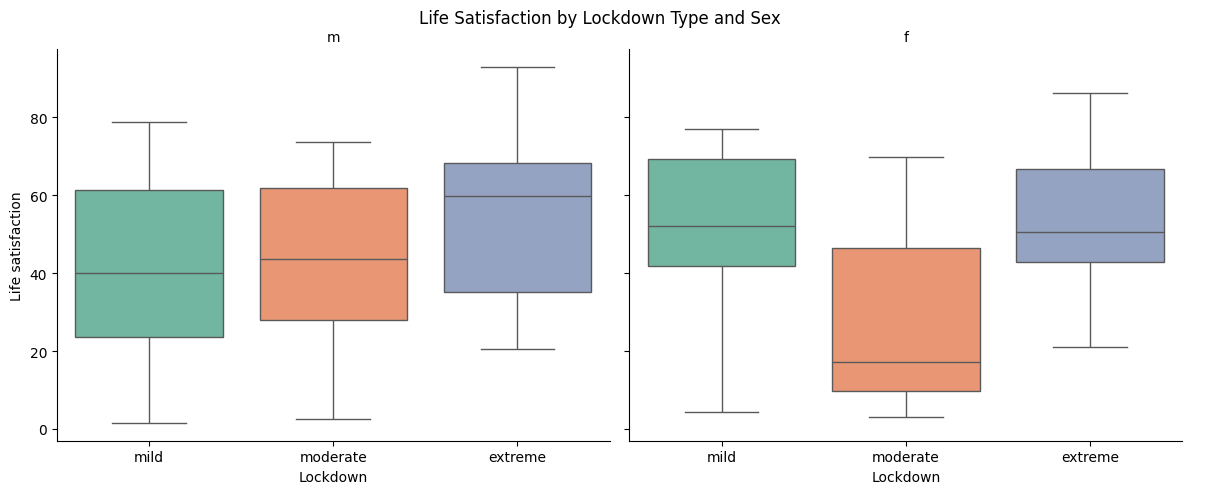

In [5]:
# Create the FacetGrid
g = sns.FacetGrid(lock_data, col="sex", height=5, aspect=1.2)

# Map the boxplot to the grid
g.map(sns.boxplot, "lockdown_type", "life_satisfaction", palette="Set2")

# Add axis labels and titles
g.set_axis_labels("Lockdown", "Life satisfaction")
g.set_titles(col_template="{col_name}")

# Adjust the layout
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Life Satisfaction by Lockdown Type and Sex")

# Show the plot
plt.show()

### 3. ANOVA (Exercise 2)

Let us compute a two-way ANOVA. The function must include the second factor (sex) as well.

In [8]:
# Perform two-way ANOVA with interaction
anova_results = pg.anova(dv='life_satisfaction', between=['lockdown_type', 'sex'], data=lock_data, detailed=True, ss_type=1)

# Display the ANOVA results
print(anova_results)

                Source            SS    DF           MS         F     p-unc  \
0        lockdown_type   4670.013748   2.0  2335.006874  4.698036  0.011639   
1                  sex     18.065485   1.0    18.065485  0.036348  0.849259   
2  lockdown_type * sex   1932.948765   2.0   966.474382  1.944547  0.149438   
3             Residual  41749.487256  84.0   497.017705       NaN       NaN   

        np2  
0  0.100605  
1  0.000433  
2  0.044250  
3       NaN  


With specification of `ss_type = 1`, `anova()` will compute the type I sum of squares. We will not recap how this works, but keep in mind that when sum of squares, the independent variables in the model will be treated sequentially. This means that the amount of variance that the second independent variable explains will be estimated after the total variance explained by the first independent variable has been computed. As such, the entire shared variance between the two predictors will be assigned to the first one, yielding biased results. Ultimately, this means that the order in which independent variables are included in the model will matter!

For example:

Run the code below. It will create the same ANOVA model as above but with inverted order of independent variables. Note that the Mean sq, F-value and its probability is different for the variable "sex" across the models.

In [9]:
# Perform two-way ANOVA with interaction
anova_results = pg.anova(dv='life_satisfaction', between=['sex', 'lockdown_type'], data=lock_data, detailed=True, ss_type=1)

# Display the ANOVA results
print(anova_results)

                Source            SS    DF           MS         F     p-unc  \
0                  sex     18.424526   1.0    18.424526  0.037070  0.847787   
1        lockdown_type   4669.654707   2.0  2334.827353  4.697674  0.011643   
2  sex * lockdown_type   1932.948765   2.0   966.474382  1.944547  0.149438   
3             Residual  41749.487256  84.0   497.017705       NaN       NaN   

        np2  
0  0.000441  
1  0.100598  
2  0.044250  
3       NaN  


This is not an issue in a one-factor design. However, in case of a factorial design with more than one independent variable, it is important to account for this and to consider all effects simultaneously. 

Note that there are 3 different types for calculating sum of squares:
Type I: Sequential, order-dependent, use with caution.
Type II: Hierarchical, ignores interactions, better than Type I for factorial designs.
Type III: With interactions, accounts for all effects, most robust and commonly used.

In our case, we can achieve the correction by using a different type of sum of squares, for example type III:

In [10]:
# Perform two-way ANOVA with interaction
anova_results_1 = pg.anova(dv='life_satisfaction', between=['sex', 'lockdown_type'], data=lock_data, detailed=True, ss_type=3)

# Display the ANOVA results
print(anova_results_1)

# Perform two-way ANOVA with interaction
anova_results_2 = pg.anova(dv='life_satisfaction', between=['lockdown_type', 'sex'], data=lock_data, detailed=True, ss_type=3)

# Display the ANOVA results
print(anova_results_2)

                Source            SS    DF           MS         F     p-unc  \
0                  sex     19.900108   1.0    19.900108  0.040039  0.841888   
1        lockdown_type   5124.304239   2.0  2562.152120  5.155052  0.007732   
2  sex * lockdown_type   1932.948765   2.0   966.474382  1.944547  0.149438   
3             Residual  41749.487256  84.0   497.017705       NaN       NaN   

        np2  
0  0.000476  
1  0.109321  
2  0.044250  
3       NaN  
                Source            SS    DF           MS         F     p-unc  \
0        lockdown_type   5124.304239   2.0  2562.152120  5.155052  0.007732   
1                  sex     19.900108   1.0    19.900108  0.040039  0.841888   
2  lockdown_type * sex   1932.948765   2.0   966.474382  1.944547  0.149438   
3             Residual  41749.487256  84.0   497.017705       NaN       NaN   

        np2  
0  0.109321  
1  0.000476  
2  0.044250  
3       NaN  


Unfortunately, an additional requirement must be fulfilled: In order to compute type III sum of squares, we are required to have **orthogonal contrasts** only, which is not the case for the dummy coding scheme that is assumed by `anova()`. In other words, performing anova with `anova()` (which estimates type I sum of squares) is recommended when there is only one independent variable. When adding a second one, and provided that we do not want to assess the effects sequentially, the computation of sum of squares type III requires us to pre-define contrasts.

Contrasts are an alternative to post hoc analysis. In fact, they are a great alternative, as we are forced to explicitly state our hypotheses á priori based on our expectations. This offers a methodological advantage because functions to perform post-hoc analysis become tedious with increasing model complexity. Additionally, pre-defining contrasts is a way to contribute to reproducible open and confirmatory science. 

*Defining orthogonal contrasts:*

Please refer to the multivariate statistics lecture I if you need to review the process of constructing orthogonal contrasts. In this example, orthogonal contrasts may be specified as follows:

In [28]:
# Define contrasts for the variables
contrast_sex = ContrastMatrix(np.array([[-1], [1]]), ["contrast_sex"])  # For variable sex
contrast_lockdown_type = ContrastMatrix(
    np.array([[-2, 0], [1, -1], [1, 1]]), ["contrast1", "contrast2"]
)  # For variable lockdown_type

# Assign contrasts to the variables using patsy
lock_data['sex'] = lock_data['sex'].astype('category')
lock_data['lockdown_type'] = lock_data['lockdown_type'].astype('category')

# Apply the contrasts
from patsy import dmatrix

# Create a design matrix with the specified contrasts
design_matrix = dmatrix(
    "C(sex, contrast_sex) + C(lockdown_type, contrast_lockdown_type)",
    data=lock_data,
    return_type="dataframe",
)

# Fit the ANOVA model
model = ols("life_satisfaction ~ C(sex, contrast_sex) * C(lockdown_type, contrast_lockdown_type)", data=lock_data).fit()

# Perform Type III ANOVA
anova_results = anova_lm(model, typ=3)

# Display the ANOVA results
print("Type III ANOVA Results:")
print(anova_results)

# Display the summary of the linear model
print("\nLinear Model Summary:")
print(model.summary())

Type III ANOVA Results:
                                                           sum_sq    df  \
Intercept                                           184809.570286   1.0   
C(sex, contrast_sex)                                    19.900108   1.0   
C(lockdown_type, contrast_lockdown_type)              5124.304239   2.0   
C(sex, contrast_sex):C(lockdown_type, contrast_...    1932.948765   2.0   
Residual                                             41749.487256  84.0   

                                                             F        PR(>F)  
Intercept                                           371.836995  1.353103e-32  
C(sex, contrast_sex)                                  0.040039  8.418879e-01  
C(lockdown_type, contrast_lockdown_type)              5.155052  7.731871e-03  
C(sex, contrast_sex):C(lockdown_type, contrast_...    1.944547  1.494378e-01  
Residual                                                   NaN           NaN  

Linear Model Summary:
                            

Interpretation:

- The ONE contrast for the variable sex coded as (-1,1) represents the difference between males and females. 

- The TWO contrasts for the variable "lockdown type", are displayed in the output. The first one represents the difference between extreme and moderate and mild together (extreme - moderate + mild). The second one represents the difference between moderate and mild.

- The remaining TWO interaction effects indicate whether the two contrasts described above (lockdown_typecontrast1 and lockdown_typecontrast2) are different in female as compared to males

### 4. Additional ANOVA models:

Due to time constrains, it is not possible to go through all possible ANOVA model types. However, keep in mind that there are many others, in which not only the number of factors and levels may be increased, but also combined. A common example is **mixed factorial ANOVA**, where both within- and between-subject factors are included into the model (see `mixed_anova()` from pingouin). 

To conclude, ANOVA models offer a wide range of possibilities that can be accommodated to the research aim and the design at hand. It is crucial to keep in mind their proper usages and limitations. For instance, while highly complex models may be used (imagine a mixed 5 * 4 * 3 factorial ANOVA), interpretability will be generally compromised. And you will see in this seminar, that ANOVA is a method that will not be able to deal with all specific issues that we face in applied (field) reasearch.